In [1]:
!nvidia-smi

Wed Jul 12 07:54:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/BackBone'

/content/drive/MyDrive/BackBone


#Import library

In [4]:
import os
import random as rn
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import cv2
from glob import glob

import matplotlib.pyplot as plt
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import seaborn as sns
import pandas as pd
import argparse
import pickle
from sklearn.utils import shuffle
import datetime
from operator import add


In [5]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations.augmentations.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
!pip install lion-pytorch
from lion_pytorch import Lion

#Datasets

##Transformation

In [6]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)
val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)


In [7]:
tf = A.Resize(224, 224)

In [8]:
from glob import glob
class Load_Data(Dataset):
    def __init__(self, folder_path , transform = None,  *args,**kwargs):
      super().__init__(*args,**kwargs)
      self.fpaths = glob(folder_path+'/images/*.png')
      self.transform = transform
    def __getitem__(self, idx):
      path = self.fpaths[idx]
      img = cv2.imread(path)
      img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
      mask= cv2.imread(path.replace('images', 'masks'))
      mask = cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
      if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img_t = transformed["image"]
            mask = transformed["mask"]
      img_t = torch.tensor(img_t)
      mask = torch.tensor(mask)
      img = cv2.resize(img, (224,224))
      return img_t,mask
    def __len__(self):
      return len(self.fpaths)

In [9]:
folder_train  = '/content/drive/MyDrive/Kvaisir-new/TrainDataset'
folder_val  = '/content/drive/MyDrive/Kvaisir-new/ValDataset'
folder_test_1  = '/content/drive/MyDrive/Kvaisir-new/TestDataset/Kvasir'
folder_test_2  = '/content/drive/MyDrive/Kvaisir-new/TestDataset/ETIS-LaribPolypDB'
folder_test_3  = '/content/drive/MyDrive/Kvaisir-new/TestDataset/CVC-ColonDB'
folder_test_4  = '/content/drive/MyDrive/Kvaisir-new/TestDataset/CVC-ClinicDB'
folder_test_5  = '/content/drive/MyDrive/Kvaisir-new/TestDataset/CVC-300'

In [10]:
train_dataset = Load_Data(folder_train, transform = train_transform)
val_dataset = Load_Data(folder_val, transform = val_transform)
test_dataset1 = Load_Data(folder_test_1, transform = val_transform)
test_dataset2 = Load_Data(folder_test_2, transform = val_transform)
test_dataset3 = Load_Data(folder_test_3, transform = val_transform)
test_dataset4 = Load_Data(folder_test_4, transform = val_transform)
test_dataset5 = Load_Data(folder_test_5, transform = val_transform)
#train_2 = Load_Data(folder_path, transform = val_transform)

##DataLoader

In [11]:
# val is on TEST folder

batch_size = 4

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0),
    'test_1': DataLoader(test_dataset1, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0),
    'test_2': DataLoader(test_dataset2, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0),
    'test_3': DataLoader(test_dataset3, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0),
    'test_4': DataLoader(test_dataset4, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0),
    'test_5': DataLoader(test_dataset5, batch_size=batch_size, shuffle=True,drop_last=True, num_workers=0)

}

dataset_sizes = {
    x: len(dataloaders[x]) for x in dataloaders.keys()
}

dataset_sizes

{'train': 362,
 'val': 25,
 'test_1': 25,
 'test_2': 49,
 'test_3': 95,
 'test_4': 15,
 'test_5': 15}

In [12]:
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

torch.Size([4, 224, 224, 3]) torch.Size([4, 224, 224, 3])
-2.117904 2.6399999 -0.016208151 1.2274866
0 255 24.992386798469386 75.80377309567399


In [13]:
def find_fish(mask):
  cmap = np.all(np.equal(mask,[255,255,0]), axis = -1)
  return cmap

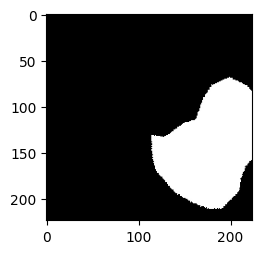

In [14]:
for i in range(1):
  plt.rcParams['figure.figsize'] = [25, 5]
  plt.subplot(1,8,i+1)
  plt.imshow(masks[i])

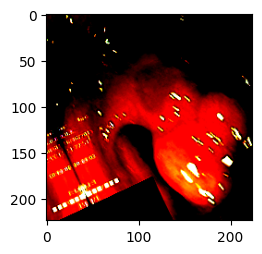

In [15]:
for i in range(1):
  plt.rcParams['figure.figsize'] = [25, 5]
  plt.subplot(1,8,i+1)
  plt.imshow(inputs[i])

In [16]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def threshold(x):
  y = np.zeros([x.shape[0],x.shape[1],x.shape[2]])
  y[x>=0.5] = 1
  y[x<0.5] = 0
  return y
def normalize(x):
  min = x.min()
  max = x.max()
  return (x-min)/(max - min)
def restore(mask):
  mask = sigmoid(mask)
  #mask = normalize(mask)
  mask = threshold(mask)
  img = np.stack([mask*255, mask*255, mask*255], axis = -1)
  return img
color_map = [[0,0,0], [255,255,0]]
def restore_mask(mask):
  return np.stack([mask*255, mask*255, mask*255], axis = -1)

#Helper function

##Fish-segment

In [17]:
def algin_mask(mask):
  cmap = np.all(np.equal(mask,[255,255,255]), axis = -1)
  return cmap

##Visualize prediction

In [18]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def threshold(x):
    y = np.zeros([x.shape[0], x.shape[1], x.shape[2]])
    y[x >= 0.5] = 1
    y[x < 0.5] = 0
    return y


def normalize(x):
    min = x.min()
    max = x.max()
    return (x-min)/(max - min)


def restore(mask):
    mask = sigmoid(mask)
    #mask = normalize(mask)
    mask = threshold(mask)
    img = np.stack([mask*255, mask*255, mask*255], axis=-1)
    return img


color_map = [[0, 0, 0], [255, 255, 0]]


def restore_mask(mask):
    return np.stack([mask*255, mask*255, mask*255], axis=-1)


##Metric

In [19]:
# custom metric
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
    #return 1.0 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def accuracy(pred, label):
    pred = torch.sigmoid(pred)
    temp = torch.zeros(pred.shape[0],pred.shape[1],pred.shape[2],pred.shape[3]).cuda()
    temp[pred>=0.5] = 255
    temp[pred<0.5] = 0
    corrects = (temp == label).float()
    acc = corrects.sum() / corrects.numel()
    return acc.item()


In [20]:
history = {
    'iou':
    {
        'train': [],
        'val': [],
        'test_1': [],
        'test_2': [],
        'test_3': [],
        'test_4': [],
        'test_5': [],
    },
    'dice_coef':
    {

        'train': [],
        'val': [],
        'test_1': [],
        'test_2': [],
        'test_3': [],
        'test_4': [],
        'test_5': [],

    },
    'loss':
    {

        'train': [],
        'val': [],
        'test_1': [],
        'test_2': [],
        'test_3': [],
        'test_4': [],
        'test_5': [],
    }
}

#Loss Function

### Loss function

In [21]:
# import torch
# import torch.nn as nn


# def dice_loss(pred, target, smooth=1.):
#     pred = pred.contiguous()
#     target = target.contiguous()

#     intersection = (pred * target).sum(dim=2).sum(dim=2)

#     loss = (1 - ((2. * intersection + smooth) /
#             (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

#     return loss.mean()


In [22]:
class FocalLossV1(nn.Module):

    def __init__(self,
                alpha=0.25,
                gamma=2,
                reduction='mean',):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        # compute loss
        logits = logits.float() # use fp32 if logits is fp16
        with torch.no_grad():
            alpha = torch.empty_like(logits).fill_(1 - self.alpha)
            alpha[label == 1] = self.alpha

        probs = torch.sigmoid(logits)
        pt = torch.where(label == 1, probs, 1 - probs)
        ce_loss = self.crit(logits, label.float())
        loss = (alpha * torch.pow(1 - pt, self.gamma) * ce_loss)
        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss

def structure_loss(pred, mask):
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wfocal = FocalLossV1()(pred, mask)
    wfocal = (wfocal*weit).sum(dim=(2,3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1)/(union - inter+1)
    return (wfocal + wiou).mean()

In [23]:
def boundary_forward(pred, gt):
    laplacian = torch.tensor([[[[-1.0, -1.0, -1.0], [-1.0, 8.0, -1.0], [-1.0, -1.0, -1.0]]]]).requires_grad_(False).to(device)
    pred = nn.Sigmoid()(pred)

    pred_edges=(F.conv2d(pred.float(), laplacian, stride=1, padding = 1) > 0.1).float()
    gt_edges = (F.conv2d(gt.float(), laplacian, stride=1, padding = 1) > 0.1).float()
    edge_loss = F.binary_cross_entropy_with_logits(input=pred_edges, target=gt_edges)

    return edge_loss


In [24]:
def calc_loss(pred,bound ,target, metrics):

    bound_loss = boundary_forward(bound, target)
    loss = structure_loss(pred,target)

    metrics['score'] += bound_loss.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss+bound_loss


#Model components

In [25]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git
!pip install git+https://github.com/hugontin/tien130102.git
!pip install timm

  Cloning https://github.com/hugontin/tien130102.git to /tmp/pip-req-build-bvhgoeym
  Running command git clone --filter=blob:none --quiet https://github.com/hugontin/tien130102.git /tmp/pip-req-build-bvhgoeym
  Resolved https://github.com/hugontin/tien130102.git to commit 4f591b6a641be5cd7bb4348a0643326a2b0384a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Mvit backbone

In [26]:
""" Multi-Scale Vision Transformer v2

@inproceedings{li2021improved,
  title={MViTv2: Improved multiscale vision transformers for classification and detection},
  author={Li, Yanghao and Wu, Chao-Yuan and Fan, Haoqi and Mangalam, Karttikeya and Xiong, Bo and Malik, Jitendra and Feichtenhofer, Christoph},
  booktitle={CVPR},
  year={2022}
}

Code adapted from original Apache 2.0 licensed impl at https://github.com/facebookresearch/mvit
Original copyright below.

Modifications and timm support by / Copyright 2022, Ross Wightman
"""
# Copyright (c) Meta Platforms, Inc. and affiliates. All Rights Reserved. All Rights Reserved.
import operator
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial, reduce
from typing import Union, List, Tuple, Optional

import torch
import torch.utils.checkpoint as checkpoint
from torch import nn

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import Mlp, DropPath, trunc_normal_tf_, get_norm_layer, to_2tuple
from timm.models._builder import build_model_with_cfg
from timm.models._features_fx import register_notrace_function
from timm.models._registry import register_model

__all__ = ['MultiScaleVit', 'MultiScaleVitCfg']  # model_registry will add each entrypoint fn to this


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head.fc',
        'fixed_input_size': True,
        **kwargs
    }


default_cfgs = dict(
    mvitv2_tiny=_cfg(url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_T_in1k.pyth'),
    mvitv2_small=_cfg(url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_S_in1k.pyth'),
    mvitv2_base=_cfg(url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_B_in1k.pyth'),
    mvitv2_large=_cfg(url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_L_in1k.pyth'),

    mvitv2_base_in21k=_cfg(
        url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_B_in21k.pyth',
        num_classes=19168),
    mvitv2_large_in21k=_cfg(
        url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_L_in21k.pyth',
        num_classes=19168),
    mvitv2_huge_in21k=_cfg(
        url='https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_H_in21k.pyth',
        num_classes=19168),

    mvitv2_small_cls=_cfg(url=''),
)


@dataclass
class MultiScaleVitCfg:
    depths: Tuple[int, ...] = (2, 3, 16, 3)
    embed_dim: Union[int, Tuple[int, ...]] = 96
    num_heads: Union[int, Tuple[int, ...]] = 1
    mlp_ratio: float = 4.
    pool_first: bool = False
    expand_attn: bool = True
    qkv_bias: bool = True
    use_cls_token: bool = False
    use_abs_pos: bool = False
    residual_pooling: bool = True
    mode: str = 'conv'
    kernel_qkv: Tuple[int, int] = (3, 3)
    stride_q: Optional[Tuple[Tuple[int, int]]] = ((1, 1), (2, 2), (2, 2), (2, 2))
    stride_kv: Optional[Tuple[Tuple[int, int]]] = None
    stride_kv_adaptive: Optional[Tuple[int, int]] = (4, 4)
    patch_kernel: Tuple[int, int] = (7, 7)
    patch_stride: Tuple[int, int] = (4, 4)
    patch_padding: Tuple[int, int] = (3, 3)
    pool_type: str = 'max'
    rel_pos_type: str = 'spatial'
    act_layer: Union[str, Tuple[str, str]] = 'gelu'
    norm_layer: Union[str, Tuple[str, str]] = 'layernorm'
    norm_eps: float = 1e-6

    def __post_init__(self):
        num_stages = len(self.depths)
        if not isinstance(self.embed_dim, (tuple, list)):
            self.embed_dim = tuple(self.embed_dim * 2 ** i for i in range(num_stages))
        assert len(self.embed_dim) == num_stages

        if not isinstance(self.num_heads, (tuple, list)):
            self.num_heads = tuple(self.num_heads * 2 ** i for i in range(num_stages))
        assert len(self.num_heads) == num_stages

        if self.stride_kv_adaptive is not None and self.stride_kv is None:
            _stride_kv = self.stride_kv_adaptive
            pool_kv_stride = []
            for i in range(num_stages):
                if min(self.stride_q[i]) > 1:
                    _stride_kv = [
                        max(_stride_kv[d] // self.stride_q[i][d], 1)
                        for d in range(len(_stride_kv))
                    ]
                pool_kv_stride.append(tuple(_stride_kv))
            self.stride_kv = tuple(pool_kv_stride)


model_cfgs = dict(
    mvitv2_tiny=MultiScaleVitCfg(
        depths=(1, 2, 5, 2),
    ),
    mvitv2_small=MultiScaleVitCfg(
        depths=(1, 2, 11, 2),
    ),
    mvitv2_base=MultiScaleVitCfg(
        depths=(2, 3, 16, 3),
    ),
    mvitv2_large=MultiScaleVitCfg(
        depths=(2, 6, 36, 4),
        embed_dim=144,
        num_heads=2,
        expand_attn=False,
    ),

    mvitv2_base_in21k=MultiScaleVitCfg(
        depths=(2, 3, 16, 3),
    ),
    mvitv2_large_in21k=MultiScaleVitCfg(
        depths=(2, 6, 36, 4),
        embed_dim=144,
        num_heads=2,
        expand_attn=False,
    ),

    mvitv2_small_cls=MultiScaleVitCfg(
        depths=(1, 2, 11, 2),
        use_cls_token=True,
    ),
)


def prod(iterable):
    return reduce(operator.mul, iterable, 1)


class PatchEmbed(nn.Module):
    """
    PatchEmbed.
    """

    def __init__(
            self,
            dim_in=3,
            dim_out=768,
            kernel=(7, 7),
            stride=(4, 4),
            padding=(3, 3),
    ):
        super().__init__()

        self.proj = nn.Conv2d(
            dim_in,
            dim_out,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
        )

    def forward(self, x) -> Tuple[torch.Tensor, List[int]]:
        x = self.proj(x)
        # B C H W -> B HW C
        return x.flatten(2).transpose(1, 2), x.shape[-2:]


@register_notrace_function
def reshape_pre_pool(
        x,
        feat_size: List[int],
        has_cls_token: bool = True
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    H, W = feat_size
    if has_cls_token:
        cls_tok, x = x[:, :, :1, :], x[:, :, 1:, :]
    else:
        cls_tok = None
    x = x.reshape(-1, H, W, x.shape[-1]).permute(0, 3, 1, 2).contiguous()
    return x, cls_tok


@register_notrace_function
def reshape_post_pool(
        x,
        num_heads: int,
        cls_tok: Optional[torch.Tensor] = None
) -> Tuple[torch.Tensor, List[int]]:
    feat_size = [x.shape[2], x.shape[3]]
    L_pooled = x.shape[2] * x.shape[3]
    x = x.reshape(-1, num_heads, x.shape[1], L_pooled).transpose(2, 3)
    if cls_tok is not None:
        x = torch.cat((cls_tok, x), dim=2)
    return x, feat_size


@register_notrace_function
def cal_rel_pos_type(
        attn: torch.Tensor,
        q: torch.Tensor,
        has_cls_token: bool,
        q_size: List[int],
        k_size: List[int],
        rel_pos_h: torch.Tensor,
        rel_pos_w: torch.Tensor,
):
    """
    Spatial Relative Positional Embeddings.
    """
    sp_idx = 1 if has_cls_token else 0
    q_h, q_w = q_size
    k_h, k_w = k_size

    # Scale up rel pos if shapes for q and k are different.
    q_h_ratio = max(k_h / q_h, 1.0)
    k_h_ratio = max(q_h / k_h, 1.0)
    dist_h = torch.arange(q_h)[:, None] * q_h_ratio - torch.arange(k_h)[None, :] * k_h_ratio
    dist_h += (k_h - 1) * k_h_ratio
    q_w_ratio = max(k_w / q_w, 1.0)
    k_w_ratio = max(q_w / k_w, 1.0)
    dist_w = torch.arange(q_w)[:, None] * q_w_ratio - torch.arange(k_w)[None, :] * k_w_ratio
    dist_w += (k_w - 1) * k_w_ratio

    Rh = rel_pos_h[dist_h.long()]
    Rw = rel_pos_w[dist_w.long()]

    B, n_head, q_N, dim = q.shape

    r_q = q[:, :, sp_idx:].reshape(B, n_head, q_h, q_w, dim)
    rel_h = torch.einsum("byhwc,hkc->byhwk", r_q, Rh)
    rel_w = torch.einsum("byhwc,wkc->byhwk", r_q, Rw)

    attn[:, :, sp_idx:, sp_idx:] = (
        attn[:, :, sp_idx:, sp_idx:].view(B, -1, q_h, q_w, k_h, k_w)
        + rel_h[:, :, :, :, :, None]
        + rel_w[:, :, :, :, None, :]
    ).view(B, -1, q_h * q_w, k_h * k_w)

    return attn


class MultiScaleAttentionPoolFirst(nn.Module):
    def __init__(
            self,
            dim,
            dim_out,
            feat_size,
            num_heads=8,
            qkv_bias=True,
            mode="conv",
            kernel_q=(1, 1),
            kernel_kv=(1, 1),
            stride_q=(1, 1),
            stride_kv=(1, 1),
            has_cls_token=True,
            rel_pos_type='spatial',
            residual_pooling=True,
            norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.dim_out = dim_out
        self.head_dim = dim_out // num_heads
        self.scale = self.head_dim ** -0.5
        self.has_cls_token = has_cls_token
        padding_q = tuple([int(q // 2) for q in kernel_q])
        padding_kv = tuple([int(kv // 2) for kv in kernel_kv])

        self.q = nn.Linear(dim, dim_out, bias=qkv_bias)
        self.k = nn.Linear(dim, dim_out, bias=qkv_bias)
        self.v = nn.Linear(dim, dim_out, bias=qkv_bias)
        self.proj = nn.Linear(dim_out, dim_out)

        # Skip pooling with kernel and stride size of (1, 1, 1).
        if prod(kernel_q) == 1 and prod(stride_q) == 1:
            kernel_q = None
        if prod(kernel_kv) == 1 and prod(stride_kv) == 1:
            kernel_kv = None
        self.mode = mode
        self.unshared = mode == 'conv_unshared'
        self.pool_q, self.pool_k, self.pool_v = None, None, None
        self.norm_q, self.norm_k, self.norm_v = None, None, None
        if mode in ("avg", "max"):
            pool_op = nn.MaxPool2d if mode == "max" else nn.AvgPool2d
            if kernel_q:
                self.pool_q = pool_op(kernel_q, stride_q, padding_q)
            if kernel_kv:
                self.pool_k = pool_op(kernel_kv, stride_kv, padding_kv)
                self.pool_v = pool_op(kernel_kv, stride_kv, padding_kv)
        elif mode == "conv" or mode == "conv_unshared":
            dim_conv = dim // num_heads if mode == "conv" else dim
            if kernel_q:
                self.pool_q = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_q,
                    stride=stride_q,
                    padding=padding_q,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_q = norm_layer(dim_conv)
            if kernel_kv:
                self.pool_k = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_kv,
                    stride=stride_kv,
                    padding=padding_kv,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_k = norm_layer(dim_conv)
                self.pool_v = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_kv,
                    stride=stride_kv,
                    padding=padding_kv,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_v = norm_layer(dim_conv)
        else:
            raise NotImplementedError(f"Unsupported model {mode}")

        # relative pos embedding
        self.rel_pos_type = rel_pos_type
        if self.rel_pos_type == 'spatial':
            assert feat_size[0] == feat_size[1]
            size = feat_size[0]
            q_size = size // stride_q[1] if len(stride_q) > 0 else size
            kv_size = size // stride_kv[1] if len(stride_kv) > 0 else size
            rel_sp_dim = 2 * max(q_size, kv_size) - 1

            self.rel_pos_h = nn.Parameter(torch.zeros(rel_sp_dim, self.head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(rel_sp_dim, self.head_dim))
            trunc_normal_tf_(self.rel_pos_h, std=0.02)
            trunc_normal_tf_(self.rel_pos_w, std=0.02)

        self.residual_pooling = residual_pooling

    def forward(self, x, feat_size: List[int]):
        B, N, _ = x.shape

        fold_dim = 1 if self.unshared else self.num_heads
        x = x.reshape(B, N, fold_dim, -1).permute(0, 2, 1, 3)
        q = k = v = x

        if self.pool_q is not None:
            q, q_tok = reshape_pre_pool(q, feat_size, self.has_cls_token)
            q = self.pool_q(q)
            q, q_size = reshape_post_pool(q, self.num_heads, q_tok)
        else:
            q_size = feat_size
        if self.norm_q is not None:
            q = self.norm_q(q)

        if self.pool_k is not None:
            k, k_tok = reshape_pre_pool(k, feat_size, self.has_cls_token)
            k = self.pool_k(k)
            k, k_size = reshape_post_pool(k, self.num_heads, k_tok)
        else:
            k_size = feat_size
        if self.norm_k is not None:
            k = self.norm_k(k)

        if self.pool_v is not None:
            v, v_tok = reshape_pre_pool(v, feat_size, self.has_cls_token)
            v = self.pool_v(v)
            v, v_size = reshape_post_pool(v, self.num_heads, v_tok)
        else:
            v_size = feat_size
        if self.norm_v is not None:
            v = self.norm_v(v)

        q_N = q_size[0] * q_size[1] + int(self.has_cls_token)
        q = q.permute(0, 2, 1, 3).reshape(B, q_N, -1)
        q = self.q(q).reshape(B, q_N, self.num_heads, -1).permute(0, 2, 1, 3)

        k_N = k_size[0] * k_size[1] + int(self.has_cls_token)
        k = k.permute(0, 2, 1, 3).reshape(B, k_N, -1)
        k = self.k(k).reshape(B, k_N, self.num_heads, -1).permute(0, 2, 1, 3)

        v_N = v_size[0] * v_size[1] + int(self.has_cls_token)
        v = v.permute(0, 2, 1, 3).reshape(B, v_N, -1)
        v = self.v(v).reshape(B, v_N, self.num_heads, -1).permute(0, 2, 1, 3)

        attn = (q * self.scale) @ k.transpose(-2, -1)
        if self.rel_pos_type == 'spatial':
            attn = cal_rel_pos_type(
                attn,
                q,
                self.has_cls_token,
                q_size,
                k_size,
                self.rel_pos_h,
                self.rel_pos_w,
            )
        attn = attn.softmax(dim=-1)
        x = attn @ v

        if self.residual_pooling:
            x = x + q

        x = x.transpose(1, 2).reshape(B, -1, self.dim_out)
        x = self.proj(x)

        return x, q_size


class MultiScaleAttention(nn.Module):
    def __init__(
            self,
            dim,
            dim_out,
            feat_size,
            num_heads=8,
            qkv_bias=True,
            mode="conv",
            kernel_q=(1, 1),
            kernel_kv=(1, 1),
            stride_q=(1, 1),
            stride_kv=(1, 1),
            has_cls_token=True,
            rel_pos_type='spatial',
            residual_pooling=True,
            norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.dim_out = dim_out
        self.head_dim = dim_out // num_heads
        self.scale = self.head_dim ** -0.5
        self.has_cls_token = has_cls_token
        padding_q = tuple([int(q // 2) for q in kernel_q])
        padding_kv = tuple([int(kv // 2) for kv in kernel_kv])

        self.qkv = nn.Linear(dim, dim_out * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim_out, dim_out)

        # Skip pooling with kernel and stride size of (1, 1, 1).
        if prod(kernel_q) == 1 and prod(stride_q) == 1:
            kernel_q = None
        if prod(kernel_kv) == 1 and prod(stride_kv) == 1:
            kernel_kv = None
        self.mode = mode
        self.unshared = mode == 'conv_unshared'
        self.norm_q, self.norm_k, self.norm_v = None, None, None
        self.pool_q, self.pool_k, self.pool_v = None, None, None
        if mode in ("avg", "max"):
            pool_op = nn.MaxPool2d if mode == "max" else nn.AvgPool2d
            if kernel_q:
                self.pool_q = pool_op(kernel_q, stride_q, padding_q)
            if kernel_kv:
                self.pool_k = pool_op(kernel_kv, stride_kv, padding_kv)
                self.pool_v = pool_op(kernel_kv, stride_kv, padding_kv)
        elif mode == "conv" or mode == "conv_unshared":
            dim_conv = dim_out // num_heads if mode == "conv" else dim_out
            if kernel_q:
                self.pool_q = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_q,
                    stride=stride_q,
                    padding=padding_q,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_q = norm_layer(dim_conv)
            if kernel_kv:
                self.pool_k = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_kv,
                    stride=stride_kv,
                    padding=padding_kv,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_k = norm_layer(dim_conv)
                self.pool_v = nn.Conv2d(
                    dim_conv,
                    dim_conv,
                    kernel_kv,
                    stride=stride_kv,
                    padding=padding_kv,
                    groups=dim_conv,
                    bias=False,
                )
                self.norm_v = norm_layer(dim_conv)
        else:
            raise NotImplementedError(f"Unsupported model {mode}")

        # relative pos embedding
        self.rel_pos_type = rel_pos_type
        if self.rel_pos_type == 'spatial':
            assert feat_size[0] == feat_size[1]
            size = feat_size[0]
            q_size = size // stride_q[1] if len(stride_q) > 0 else size
            kv_size = size // stride_kv[1] if len(stride_kv) > 0 else size
            rel_sp_dim = 2 * max(q_size, kv_size) - 1

            self.rel_pos_h = nn.Parameter(torch.zeros(rel_sp_dim, self.head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(rel_sp_dim, self.head_dim))
            trunc_normal_tf_(self.rel_pos_h, std=0.02)
            trunc_normal_tf_(self.rel_pos_w, std=0.02)

        self.residual_pooling = residual_pooling

    def forward(self, x, feat_size: List[int]):
        B, N, _ = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(dim=0)

        if self.pool_q is not None:
            q, q_tok = reshape_pre_pool(q, feat_size, self.has_cls_token)
            q = self.pool_q(q)
            q, q_size = reshape_post_pool(q, self.num_heads, q_tok)
        else:
            q_size = feat_size
        if self.norm_q is not None:
            q = self.norm_q(q)

        if self.pool_k is not None:
            k, k_tok = reshape_pre_pool(k, feat_size, self.has_cls_token)
            k = self.pool_k(k)
            k, k_size = reshape_post_pool(k, self.num_heads, k_tok)
        else:
            k_size = feat_size
        if self.norm_k is not None:
            k = self.norm_k(k)

        if self.pool_v is not None:
            v, v_tok = reshape_pre_pool(v, feat_size, self.has_cls_token)
            v = self.pool_v(v)
            v, _ = reshape_post_pool(v, self.num_heads, v_tok)
        if self.norm_v is not None:
            v = self.norm_v(v)

        attn = (q * self.scale) @ k.transpose(-2, -1)
        if self.rel_pos_type == 'spatial':
            attn = cal_rel_pos_type(
                attn,
                q,
                self.has_cls_token,
                q_size,
                k_size,
                self.rel_pos_h,
                self.rel_pos_w,
            )
        attn = attn.softmax(dim=-1)
        x = attn @ v

        if self.residual_pooling:
            x = x + q

        x = x.transpose(1, 2).reshape(B, -1, self.dim_out)
        x = self.proj(x)

        return x, q_size


class MultiScaleBlock(nn.Module):
    def __init__(
            self,
            dim,
            dim_out,
            num_heads,
            feat_size,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path=0.0,
            norm_layer=nn.LayerNorm,
            kernel_q=(1, 1),
            kernel_kv=(1, 1),
            stride_q=(1, 1),
            stride_kv=(1, 1),
            mode="conv",
            has_cls_token=True,
            expand_attn=False,
            pool_first=False,
            rel_pos_type='spatial',
            residual_pooling=True,
    ):
        super().__init__()
        proj_needed = dim != dim_out
        self.dim = dim
        self.dim_out = dim_out
        self.has_cls_token = has_cls_token

        self.norm1 = norm_layer(dim)

        self.shortcut_proj_attn = nn.Linear(dim, dim_out) if proj_needed and expand_attn else None
        if stride_q and prod(stride_q) > 1:
            kernel_skip = [s + 1 if s > 1 else s for s in stride_q]
            stride_skip = stride_q
            padding_skip = [int(skip // 2) for skip in kernel_skip]
            self.shortcut_pool_attn = nn.MaxPool2d(kernel_skip, stride_skip, padding_skip)
        else:
            self.shortcut_pool_attn = None

        att_dim = dim_out if expand_attn else dim
        attn_layer = MultiScaleAttentionPoolFirst if pool_first else MultiScaleAttention
        self.attn = attn_layer(
            dim,
            att_dim,
            num_heads=num_heads,
            feat_size=feat_size,
            qkv_bias=qkv_bias,
            kernel_q=kernel_q,
            kernel_kv=kernel_kv,
            stride_q=stride_q,
            stride_kv=stride_kv,
            norm_layer=norm_layer,
            has_cls_token=has_cls_token,
            mode=mode,
            rel_pos_type=rel_pos_type,
            residual_pooling=residual_pooling,
        )
        self.drop_path1 = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        self.norm2 = norm_layer(att_dim)
        mlp_dim_out = dim_out
        self.shortcut_proj_mlp = nn.Linear(dim, dim_out) if proj_needed and not expand_attn else None
        self.mlp = Mlp(
            in_features=att_dim,
            hidden_features=int(att_dim * mlp_ratio),
            out_features=mlp_dim_out,
        )
        self.drop_path2 = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def _shortcut_pool(self, x, feat_size: List[int]):
        if self.shortcut_pool_attn is None:
            return x
        if self.has_cls_token:
            cls_tok, x = x[:, :1, :], x[:, 1:, :]
        else:
            cls_tok = None
        B, L, C = x.shape
        H, W = feat_size
        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        x = self.shortcut_pool_attn(x)
        x = x.reshape(B, C, -1).transpose(1, 2)
        if cls_tok is not None:
            x = torch.cat((cls_tok, x), dim=1)
        return x

    def forward(self, x, feat_size: List[int]):
        x_norm = self.norm1(x)
        # NOTE as per the original impl, this seems odd, but shortcut uses un-normalized input if no proj
        x_shortcut = x if self.shortcut_proj_attn is None else self.shortcut_proj_attn(x_norm)
        x_shortcut = self._shortcut_pool(x_shortcut, feat_size)
        x, feat_size_new = self.attn(x_norm, feat_size)
        x = x_shortcut + self.drop_path1(x)

        x_norm = self.norm2(x)
        x_shortcut = x if self.shortcut_proj_mlp is None else self.shortcut_proj_mlp(x_norm)
        x = x_shortcut + self.drop_path2(self.mlp(x_norm))
        return x, feat_size_new


class MultiScaleVitStage(nn.Module):

    def __init__(
            self,
            dim,
            dim_out,
            depth,
            num_heads,
            feat_size,
            mlp_ratio=4.0,
            qkv_bias=True,
            mode="conv",
            kernel_q=(1, 1),
            kernel_kv=(1, 1),
            stride_q=(1, 1),
            stride_kv=(1, 1),
            has_cls_token=True,
            expand_attn=False,
            pool_first=False,
            rel_pos_type='spatial',
            residual_pooling=True,
            norm_layer=nn.LayerNorm,
            drop_path=0.0,
    ):
        super().__init__()
        self.grad_checkpointing = False

        self.blocks = nn.ModuleList()
        if expand_attn:
            out_dims = (dim_out,) * depth
        else:
            out_dims = (dim,) * (depth - 1) + (dim_out,)

        for i in range(depth):
            attention_block = MultiScaleBlock(
                dim=dim,
                dim_out=out_dims[i],
                num_heads=num_heads,
                feat_size=feat_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                kernel_q=kernel_q,
                kernel_kv=kernel_kv,
                stride_q=stride_q if i == 0 else (1, 1),
                stride_kv=stride_kv,
                mode=mode,
                has_cls_token=has_cls_token,
                pool_first=pool_first,
                rel_pos_type=rel_pos_type,
                residual_pooling=residual_pooling,
                expand_attn=expand_attn,
                norm_layer=norm_layer,
                drop_path=drop_path[i] if isinstance(drop_path, (list, tuple)) else drop_path,
            )
            dim = out_dims[i]
            self.blocks.append(attention_block)
            if i == 0:
                feat_size = tuple([size // stride for size, stride in zip(feat_size, stride_q)])

        self.feat_size = feat_size

    def forward(self, x, feat_size: List[int]):
        for blk in self.blocks:
            if self.grad_checkpointing and not torch.jit.is_scripting():
                x, feat_size = checkpoint.checkpoint(blk, x, feat_size)
            else:
                x, feat_size = blk(x, feat_size)
        return x, feat_size


class MultiScaleVit(nn.Module):
    """
    Improved Multiscale Vision Transformers for Classification and Detection
    Yanghao Li*, Chao-Yuan Wu*, Haoqi Fan, Karttikeya Mangalam, Bo Xiong, Jitendra Malik,
        Christoph Feichtenhofer*
    https://arxiv.org/abs/2112.01526

    Multiscale Vision Transformers
    Haoqi Fan*, Bo Xiong*, Karttikeya Mangalam*, Yanghao Li*, Zhicheng Yan, Jitendra Malik,
        Christoph Feichtenhofer*
    https://arxiv.org/abs/2104.11227
    """

    def __init__(
            self,
            cfg: MultiScaleVitCfg,
            img_size: Tuple[int, int] = (224, 224),
            in_chans: int = 3,
            global_pool: str = 'avg',
            num_classes: int = 1000,
            drop_path_rate: float = 0.,
            drop_rate: float = 0.,
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        norm_layer = partial(get_norm_layer(cfg.norm_layer), eps=cfg.norm_eps)
        self.num_classes = num_classes
        self.drop_rate = drop_rate
        self.global_pool = global_pool
        self.depths = tuple(cfg.depths)
        self.expand_attn = cfg.expand_attn

        embed_dim = cfg.embed_dim[0]
        self.patch_embed = PatchEmbed(
            dim_in=in_chans,
            dim_out=embed_dim,
            kernel=cfg.patch_kernel,
            stride=cfg.patch_stride,
            padding=cfg.patch_padding,
        )
        patch_dims = (img_size[0] // cfg.patch_stride[0], img_size[1] // cfg.patch_stride[1])
        num_patches = prod(patch_dims)

        if cfg.use_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
            self.num_prefix_tokens = 1
            pos_embed_dim = num_patches + 1
        else:
            self.num_prefix_tokens = 0
            self.cls_token = None
            pos_embed_dim = num_patches

        if cfg.use_abs_pos:
            self.pos_embed = nn.Parameter(torch.zeros(1, pos_embed_dim, embed_dim))
        else:
            self.pos_embed = None

        num_stages = len(cfg.embed_dim)
        feat_size = patch_dims
        dpr = [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(cfg.depths)).split(cfg.depths)]
        self.stages = nn.ModuleList()
        for i in range(num_stages):
            if cfg.expand_attn:
                dim_out = cfg.embed_dim[i]
            else:
                dim_out = cfg.embed_dim[min(i + 1, num_stages - 1)]
            stage = MultiScaleVitStage(
                dim=embed_dim,
                dim_out=dim_out,
                depth=cfg.depths[i],
                num_heads=cfg.num_heads[i],
                feat_size=feat_size,
                mlp_ratio=cfg.mlp_ratio,
                qkv_bias=cfg.qkv_bias,
                mode=cfg.mode,
                pool_first=cfg.pool_first,
                expand_attn=cfg.expand_attn,
                kernel_q=cfg.kernel_qkv,
                kernel_kv=cfg.kernel_qkv,
                stride_q=cfg.stride_q[i],
                stride_kv=cfg.stride_kv[i],
                has_cls_token=cfg.use_cls_token,
                rel_pos_type=cfg.rel_pos_type,
                residual_pooling=cfg.residual_pooling,
                norm_layer=norm_layer,
                drop_path=dpr[i],
            )
            embed_dim = dim_out
            feat_size = stage.feat_size
            self.stages.append(stage)

        self.num_features = embed_dim
        self.norm = norm_layer(embed_dim)
        self.head = nn.Sequential(OrderedDict([
            ('drop', nn.Dropout(self.drop_rate)),
            ('fc', nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity())
        ]))

        if self.pos_embed is not None:
            trunc_normal_tf_(self.pos_embed, std=0.02)
        if self.cls_token is not None:
            trunc_normal_tf_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_tf_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {k for k, _ in self.named_parameters()
                if any(n in k for n in ["pos_embed", "rel_pos_h", "rel_pos_w", "cls_token"])}

    @torch.jit.ignore
    def group_matcher(self, coarse=False):
        matcher = dict(
            stem=r'^patch_embed',  # stem and embed
            blocks=[(r'^stages\.(\d+)', None), (r'^norm', (99999,))]
        )
        return matcher

    @torch.jit.ignore
    def set_grad_checkpointing(self, enable=True):
        for s in self.stages:
            s.grad_checkpointing = enable

    @torch.jit.ignore
    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes, global_pool=None):
        self.num_classes = num_classes
        if global_pool is not None:
            self.global_pool = global_pool
        self.head = nn.Sequential(OrderedDict([
            ('drop', nn.Dropout(self.drop_rate)),
            ('fc', nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity())
        ]))

    def forward_features(self, x):
        x, feat_size = self.patch_embed(x)
        B, N, C = x.shape

        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        if self.pos_embed is not None:
            x = x + self.pos_embed

        for stage in self.stages:
            x, feat_size = stage(x, feat_size)

        x = self.norm(x)
        return x


    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            if self.global_pool == 'avg':
                x = x[:, self.num_prefix_tokens:].mean(1)
            else:
                x = x[:, 0]
        return x if pre_logits else self.head(x)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x
    def get_features(self, x):
        x, feat_size = self.patch_embed(x)
        B, N, C = x.shape
        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        if self.pos_embed is not None:
            x = x + self.pos_embed
        features=[]
        # bs,n,f=x.shape
        # h = int(n**0.5)
        # features= [x.view(-1,h,h,f).permute(0, 3, 1, 2).contiguous()]
        for stage in self.stages:
            x, feat_size = stage(x, feat_size)
            bs,n,f=x.shape
            h = int(n**0.5)
            features.append(x.view(-1,h,h,f).permute(0, 3, 1, 2).contiguous())
        return features


def checkpoint_filter_fn(state_dict, model):
    if 'stages.0.blocks.0.norm1.weight' in state_dict:
        return state_dict

    import re
    if 'model_state' in state_dict:
        state_dict = state_dict['model_state']

    depths = getattr(model, 'depths', None)
    expand_attn = getattr(model, 'expand_attn', True)
    assert depths is not None, 'model requires depth attribute to remap checkpoints'
    depth_map = {}
    block_idx = 0
    for stage_idx, d in enumerate(depths):
        depth_map.update({i: (stage_idx, i - block_idx) for i in range(block_idx, block_idx + d)})
        block_idx += d

    out_dict = {}
    for k, v in state_dict.items():
        k = re.sub(
            r'blocks\.(\d+)',
            lambda x: f'stages.{depth_map[int(x.group(1))][0]}.blocks.{depth_map[int(x.group(1))][1]}',
            k)

        if expand_attn:
            k = re.sub(r'stages\.(\d+).blocks\.(\d+).proj', f'stages.\\1.blocks.\\2.shortcut_proj_attn', k)
        else:
            k = re.sub(r'stages\.(\d+).blocks\.(\d+).proj', f'stages.\\1.blocks.\\2.shortcut_proj_mlp', k)
        if 'head' in k:
            k = k.replace('head.projection', 'head.fc')
        out_dict[k] = v

    # for k, v in state_dict.items():
    #     if model.pos_embed is not None and k == 'pos_embed' and v.shape[1] != model.pos_embed.shape[1]:
    #         # To resize pos embedding when using model at different size from pretrained weights
    #         v = resize_pos_embed(
    #             v,
    #             model.pos_embed,
    #             0 if getattr(model, 'no_embed_class') else getattr(model, 'num_prefix_tokens', 1),
    #             model.patch_embed.grid_size
    #         )

    return out_dict


def _create_mvitv2(variant, cfg_variant=None, pretrained=False, **kwargs):
    return build_model_with_cfg(
        MultiScaleVit, variant, pretrained,
        model_cfg=model_cfgs[variant] if not cfg_variant else model_cfgs[cfg_variant],
        pretrained_filter_fn=checkpoint_filter_fn,
        feature_cfg=dict(flatten_sequential=True),
        **kwargs)


@register_model
def mvitv2_tiny(pretrained=False, **kwargs):
    return _create_mvitv2('mvitv2_tiny', pretrained=pretrained, **kwargs)


@register_model
def mvitv2_small(pretrained=False, **kwargs):
    return _create_mvitv2('mvitv2_small', pretrained=pretrained, **kwargs)


@register_model
def mvitv2_base(pretrained=False, **kwargs):
    return _create_mvitv2('mvitv2_base', pretrained=pretrained, **kwargs)


@register_model
def mvitv2_large(pretrained=False, **kwargs):
    return _create_mvitv2('mvitv2_large', pretrained=pretrained, **kwargs)

@register_model
def mvitv2_small_cls(pretrained=False, **kwargs):
    return _create_mvitv2('mvitv2_small_cls', pretrained=pretrained, **kwargs)

In [27]:
backbone=mvitv2_small(pretrained=True)

##GLSA

In [28]:
class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return  res1+res2

In [29]:
# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)

#         self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
#         self.relu1 = nn.ReLU()
#         self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
#         max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
#         out = avg_out + max_out
#         return self.sigmoid(out)

In [30]:
class ChannelAttention(nn.Module):
    r'''
    Global channel attention(GCA)
    '''
    def __init__(self, kernel_size=1):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv_q = nn.Conv1d(1, 1, kernel_size, stride=1, padding=(kernel_size - 1)//2)
        self.conv_k = nn.Conv1d(1, 1, kernel_size, stride=1, padding=(kernel_size - 1)//2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature):
        r'''
        feature: shape (B, C, H, W)
        1. Apply global average pooling(GAP) and squeeze spatial dimensions.
        2. Apply 1D convolution of kernel size k and a sigmoid function.
        3. Get 1*c query(Q) and key(K).
        4. Get value(V) by reshaping feature to hw*c without GAP.
        5. Perform the outer product of K and Q, followed by softmax over channels,
        and obtain c*c global channel attention map.
        Att = softmax(K^TQ)
        6. Obtain attention feature map by performing matrix product of V and Att and
        reshape back to (B, C, H, W)
        '''
        b, c, h, w = feature.shape
        feature_gap = self.gap(feature).reshape(b, 1, c)  # (b, c, 1, 1) -> (b, 1, c)
        query = F.sigmoid(self.conv_q(feature_gap))  # (b, 1, c)
        key = F.sigmoid(self.conv_k(feature_gap))  # (b, 1, c)
        value = feature.reshape(b, h*w, c)  # (b, h*w, c)
        att = torch.matmul(key.transpose(1, 2), query)  # (b, c, c)
        att = self.softmax(att)
        feature_gc = torch.matmul(value, att)  # (b, h*w, c)
        feature_gc = feature_gc.reshape(b, c, h, w)
        return feature_gc


In [31]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [32]:
class LocalChannelAttention(nn.Module):
    r'''
    Local channel attention.
    '''
    def __init__(self, in_channels, kernel_size=1):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1)//2)

    def forward(self, feature):
        r'''
        feature: shape (B, C, H, W)
        1. Apply global average pooling to reduce tensor to shape (B, C, 1, 1)
        '''
        b, c, h, w = feature.shape
        feature_gap = self.gap(feature)  # (b, c, 1, 1)
        feature_lc = self.conv(feature_gap.reshape(b, c, 1)).reshape(b, c, 1, 1)
        feature_lc = F.sigmoid(feature_lc)
        return feature_lc


class LocalSpatialAttention(nn.Module):
    r'''
    Local spatial attention.
    '''
    def __init__(self, in_channels, embedding_num):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, embedding_num, 1)
        self.conv3 = nn.Conv2d(embedding_num, embedding_num, 3, padding=1, dilation=1)
        self.conv5 = nn.Conv2d(embedding_num, embedding_num, 3, padding=2, dilation=2)
        self.conv7 = nn.Conv2d(embedding_num, embedding_num, 3, padding=3, dilation=3)
        self.conv_ls = nn.Conv2d(4*embedding_num, 1, 1)

    def forward(self, feature):
        b, c, h, w = feature.shape
        f1 = self.conv1(feature)  # (b, c', h, w)
        f3 = self.conv3(f1)  # (b, c', h, w)
        f5 = self.conv5(f1)  # (b, c', h, w)
        f7 = self.conv7(f1)  # (b, c', h, w)
        fea_concat = torch.cat((f1, f3, f5, f7), 1)  # (b, 4c', h, w)
        feature_ls = self.conv_ls(fea_concat)  # (b, 1, h, w)
        return feature_ls


class LocalAttention(nn.Module):
    r'''
    Local attention module.
    '''
    def __init__(self, in_channels, embedding_num, kernel_size=1):
        super().__init__()
        self.lca = LocalChannelAttention(in_channels, kernel_size=kernel_size)
        self.lsa = LocalSpatialAttention(in_channels, embedding_num)

    def forward(self, feature):
        att_c = self.lca(feature)  # (b, c, 1, 1)
        att_s = self.lsa(feature)  # (b, 1, h, w)
        feature_lc = feature * att_c + feature  # (b, c, h, w)
        feature_local = feature_lc * att_s + feature_lc  # (b, c, h, w)
        return feature_local



In [33]:
class ChannelPool(nn.Module):
    def __init__(self):
      super(ChannelPool,self).__init__()
    def forward(self, x):
        return torch.cat( [torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)], dim=1 )

In [34]:
class Context_block(nn.Module):
  def __init__(self,c_in):
    super(Context_block,self).__init__()
    self.ca = ChannelAttention(3)
    self.conv_3x3 = nn.Conv2d(c_in,c_in,kernel_size=3,padding=1,stride=1)
    self.sa = SpatialAttention()
    self.out_layer = nn.Conv2d(2*c_in,c_in,kernel_size=3,padding=1)

  def forward(self,x):
    #Channel attention
    b,c,h,w = x.shape
    out_channel = self.ca(x)
    #Convolution
    out_conv    = self.conv_3x3(x)
    #Spatial attention
    out_spatial = self.sa(x) * x

    out1 = out_conv * out_channel
    out2 = out_conv * out_spatial
    out  = torch.cat([out1,out2],dim=1)
    out  = self.out_layer(out)
    return out

In [35]:
class GLSA(nn.Module):
    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()

        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = Context_block(embed_dim)
        self.local = LocalAttention(embed_dim,  embed_dim,3)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)

    # local block
        local = self.local(self.local_11conv(x_0))

    # Globel block
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x

##ResBlock

In [36]:
class RB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
        )

        self.out_layers = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
        )

        if out_channels == in_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        h = self.in_layers(x)
        h = self.out_layers(h)
        return h + self.skip(x)

##SBA

In [37]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [38]:
def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

In [39]:
class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)


        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)

        self.Sigmoid = nn.Sigmoid()

    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)

        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)

        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False)

        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out


##Mvit model

In [40]:
class Mvit_Net(nn.Module):

    def __init__(self,backbone,dims=(96,96*2,96*4,96*8),depths=(14,28,56,56)):
        super(Mvit_Net, self).__init__()

        # Backbone
        self.backbone = backbone

        self.sba = SBA(32)
        #attention
        self.attention0=GLSA(dims[0])
        self.attention1=GLSA(dims[1])
        self.attention2=GLSA(dims[2])
        self.attention3=GLSA(dims[3])

        # go through LP Header
        self.conv = BasicConv2d(96,32,3,1,1)
        self.linear_fuse=BasicConv2d(64,32,1)
        self.RB = nn.Sequential(
                RB(64, 32), RB(32, 32))

        self.Multi = nn.ModuleList([])
        for i in range(4):
          self.Multi.append(nn.Sequential(
                    RB([32, 96,96 , 512][i], [64,64,64,64][i]), RB(64, 64))
                           )
        self.Up=nn.Upsample(size=224)
        self.Near = nn.Sequential(
                RB(96, 64), RB(64, 64))
        self.End=  nn.Sequential(
                RB(64, 64), RB(64, 64), nn.Conv2d(64, 1, kernel_size=1)
            )
    def forward(self, x):

        ##################  Go through backbone ###################
        pyramid=self.backbone.get_features(x)
        pyramid0=pyramid[0]
        pyramid1=self.attention1(pyramid[1])
        pyramid2=self.attention2(pyramid[2])
        pyramid3=self.attention3(pyramid[3])

        py3=pyramid3
        py2=pyramid2
        py1=pyramid1
        py0=self.conv(pyramid0)

        py3mix=self.Multi[0](py3)
        py2mix=self.Multi[1](torch.cat((F.interpolate(py3mix,scale_factor=2,mode='bilinear', align_corners=False),
                             py2),dim=1))
        py1mix=self.Multi[2](torch.cat((F.interpolate(py2mix,scale_factor=2,mode='bilinear', align_corners=False),
                             py1),dim=1))

        cfm_feature = torch.cat((F.interpolate(py1mix,scale_factor=2,mode='bilinear', align_corners=False),
                             py0),dim=1)

        ##SBA###
        feature_h = F.interpolate(py2mix,scale_factor=2,mode='bilinear', align_corners=False)
        feature_h =self.linear_fuse(feature_h)
        output = self.sba(feature_h,py0)
        out2=self.Up(output)

        ##output##
        out1=self.Near(cfm_feature)
        out1=self.End(out1)
        out1 = F.interpolate(out1,scale_factor=4,mode='bilinear', align_corners=False)
        return out1,out2

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Mvit_Net(backbone)
model = model.to(device)

cuda


In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_param=count_parameters(model)
num_param

36491253

# Training

In [43]:
from torch.cuda import amp
scaler = amp.GradScaler()

In [44]:
from collections import defaultdict
import torch.nn.functional as F
from tqdm import tqdm


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        if k =='iou' or k == 'dice_coef':
          outputs.append("{}: {:4f}".format(k, metrics[k]))
        else:
          outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))


    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, optimizer, scheduler, history, patience, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    counter = 0
    best_dice = [0,0,0,0,0]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test_1', 'test_2', 'test_3', 'test_4', 'test_5']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            dice = 0
            iou = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                labels = np.asarray(labels)
                labels = algin_mask(labels)
                labels = torch.tensor(labels)
                inputs = inputs.permute(0, 3, 1, 2).float().to(device)
                labels = labels.unsqueeze(1).float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,outputs1 = model(inputs)
                    loss = calc_loss(outputs, outputs1,labels, metrics)
                    dice += dice_coef(outputs, labels)
                    iou += iou_score(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                # statistics
                epoch_samples += inputs.size(0)
            metrics['iou'] = iou/len(dataloaders[phase])
            metrics['dice_coef'] = dice/len(dataloaders[phase])
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            history['dice_coef'][phase].append(dice/len(dataloaders[phase]))
            history['iou'][phase].append(iou/len(dataloaders[phase]))
            history['loss'][phase].append(epoch_loss)

            if phase == 'val':

                if epoch_loss < best_loss:
                    print("saving best model")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    counter = 0
                else:
                  counter = counter + 1
            if phase == 'test_1':
                if dice/len(dataloaders[phase]) > best_dice[0]:
                    best_dice[0] = dice/len(dataloaders[phase])
                    print('save best weight of kvasir')
                    torch.save(model.state_dict(),'kvasir.pt')
            if phase == 'test_2':
                if dice/len(dataloaders[phase]) > best_dice[1]:
                    best_dice[1] = dice/len(dataloaders[phase])
                    print('save best weight of etis')
                    torch.save(model.state_dict(),'etis.pt')
            if phase == 'test_3':
                if dice/len(dataloaders[phase]) > best_dice[2]:
                    best_dice[2] = dice/len(dataloaders[phase])
                    print('save best weight of clonDB')
                    torch.save(model.state_dict(),'ClonDB.pt')
            if phase == 'test_4':
                if dice/len(dataloaders[phase]) > best_dice[3]:
                    best_dice[3] = dice/len(dataloaders[phase])
                    print('save best weight of clinDB')
                    torch.save(model.state_dict(),'ClinDB.pt')
            if phase == 'test_5':
                if dice/len(dataloaders[phase]) > best_dice[4]:
                    best_dice[4] = dice/len(dataloaders[phase])
                    print('save best weight of CVC-300')
                    torch.save(model.state_dict(),'CVC300.pt')
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        if counter > patience:
                  break
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#num_class = 1

model = model.to(device)

cuda:0


In [46]:
import torch.nn.functional as F

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy


print(device)

#num_class = 1


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
# optimizer_ft = Lion(model.parameters(), lr=1e-4,betas = (0.9, 0.99), weight_decay = 0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.4)

model, history= train_model(model, optimizer_ft, exp_lr_scheduler, history, patience = 30, num_epochs=100) #increase the num_epochs for better results

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


cuda:0
Epoch 1/100
----------
LR 0.0001


100%|██████████| 362/362 [01:43<00:00,  3.48it/s]


train: score: 0.833542, loss: 0.481284, iou: 0.632188, dice_coef: 0.715847


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


val: score: 0.846334, loss: 0.314348, iou: 0.763430, dice_coef: 0.834656
saving best model


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


test_1: score: 0.846334, loss: 0.314348, iou: 0.785746, dice_coef: 0.852214
save best weight of kvasir


100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


test_2: score: 0.843597, loss: 0.503550, iou: 0.523009, dice_coef: 0.627897
save best weight of etis


100%|██████████| 95/95 [00:15<00:00,  6.15it/s]


test_3: score: 0.820737, loss: 0.469016, iou: 0.576816, dice_coef: 0.685402
save best weight of clonDB


100%|██████████| 15/15 [00:01<00:00,  9.02it/s]


test_4: score: 0.828860, loss: 0.348229, iou: 0.696172, dice_coef: 0.787388
save best weight of clinDB


100%|██████████| 15/15 [00:02<00:00,  7.41it/s]


test_5: score: 0.818847, loss: 0.269804, iou: 0.752005, dice_coef: 0.816207
save best weight of CVC-300
2m 31s
Epoch 2/100
----------
LR 0.0001


100%|██████████| 362/362 [01:29<00:00,  4.04it/s]


train: score: 0.833870, loss: 0.293437, iou: 0.793473, dice_coef: 0.863590


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


val: score: 0.845173, loss: 0.260317, iou: 0.818111, dice_coef: 0.884582
saving best model


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


test_1: score: 0.845172, loss: 0.260317, iou: 0.824823, dice_coef: 0.888585
save best weight of kvasir


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


test_2: score: 0.842810, loss: 0.423918, iou: 0.608792, dice_coef: 0.712418
save best weight of etis


100%|██████████| 95/95 [00:14<00:00,  6.41it/s]


test_3: score: 0.817528, loss: 0.389920, iou: 0.660004, dice_coef: 0.757108
save best weight of clonDB


100%|██████████| 15/15 [00:02<00:00,  7.25it/s]


test_4: score: 0.827030, loss: 0.251304, iou: 0.802702, dice_coef: 0.870066
save best weight of clinDB


100%|██████████| 15/15 [00:02<00:00,  7.40it/s]


test_5: score: 0.814672, loss: 0.256652, iou: 0.715283, dice_coef: 0.809573
2m 13s
Epoch 3/100
----------
LR 0.0001


100%|██████████| 362/362 [01:31<00:00,  3.97it/s]


train: score: 0.832694, loss: 0.275486, iou: 0.802267, dice_coef: 0.870069


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


val: score: 0.846853, loss: 0.291993, iou: 0.784263, dice_coef: 0.857121


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


test_1: score: 0.846853, loss: 0.291993, iou: 0.779443, dice_coef: 0.856166


100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


test_2: score: 0.847440, loss: 0.397771, iou: 0.615432, dice_coef: 0.706802


100%|██████████| 95/95 [00:14<00:00,  6.54it/s]


test_3: score: 0.822188, loss: 0.399285, iou: 0.640754, dice_coef: 0.742531


100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


test_4: score: 0.831049, loss: 0.279815, iou: 0.771824, dice_coef: 0.837822


100%|██████████| 15/15 [00:01<00:00,  7.67it/s]


test_5: score: 0.820920, loss: 0.258666, iou: 0.724875, dice_coef: 0.812342
2m 14s
Epoch 4/100
----------
LR 0.0001


100%|██████████| 362/362 [01:30<00:00,  3.99it/s]


train: score: 0.834758, loss: 0.242519, iou: 0.836054, dice_coef: 0.894928


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


val: score: 0.846706, loss: 0.260747, iou: 0.822382, dice_coef: 0.887990


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


test_1: score: 0.846706, loss: 0.260747, iou: 0.820244, dice_coef: 0.886696


100%|██████████| 49/49 [00:14<00:00,  3.39it/s]


test_2: score: 0.845124, loss: 0.370963, iou: 0.675761, dice_coef: 0.772577
save best weight of etis


100%|██████████| 95/95 [00:14<00:00,  6.73it/s]


test_3: score: 0.822638, loss: 0.382674, iou: 0.645046, dice_coef: 0.747642


100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


test_4: score: 0.832283, loss: 0.217772, iou: 0.860725, dice_coef: 0.911500
save best weight of clinDB


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]


test_5: score: 0.818886, loss: 0.233863, iou: 0.768790, dice_coef: 0.854194
save best weight of CVC-300
2m 12s
Epoch 5/100
----------
LR 0.0001


100%|██████████| 362/362 [01:28<00:00,  4.09it/s]


train: score: 0.832757, loss: 0.225726, iou: 0.859177, dice_coef: 0.913149


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


val: score: 0.843212, loss: 0.254905, iou: 0.817141, dice_coef: 0.881586
saving best model


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


test_1: score: 0.843212, loss: 0.254905, iou: 0.828232, dice_coef: 0.894476
save best weight of kvasir


100%|██████████| 49/49 [00:15<00:00,  3.26it/s]


test_2: score: 0.841041, loss: 0.399038, iou: 0.649455, dice_coef: 0.750124


100%|██████████| 95/95 [00:15<00:00,  6.23it/s]


test_3: score: 0.823095, loss: 0.355908, iou: 0.708863, dice_coef: 0.800176
save best weight of clonDB


100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


test_4: score: 0.829784, loss: 0.230130, iou: 0.816607, dice_coef: 0.881369


100%|██████████| 15/15 [00:01<00:00,  8.06it/s]


test_5: score: 0.820940, loss: 0.206343, iou: 0.793310, dice_coef: 0.866965
save best weight of CVC-300
2m 11s
Epoch 6/100
----------
LR 0.0001


100%|██████████| 362/362 [01:27<00:00,  4.13it/s]


train: score: 0.832283, loss: 0.226159, iou: 0.848458, dice_coef: 0.902789


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


val: score: 0.844798, loss: 0.293582, iou: 0.801938, dice_coef: 0.865953


100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


test_1: score: 0.844798, loss: 0.293582, iou: 0.787954, dice_coef: 0.855988


100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


test_2: score: 0.845194, loss: 0.385417, iou: 0.626859, dice_coef: 0.736547


100%|██████████| 95/95 [00:13<00:00,  6.82it/s]


test_3: score: 0.822996, loss: 0.376093, iou: 0.639105, dice_coef: 0.740715


100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


test_4: score: 0.829344, loss: 0.231610, iou: 0.830834, dice_coef: 0.893504


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


test_5: score: 0.822344, loss: 0.225627, iou: 0.784801, dice_coef: 0.866133
2m 7s
Epoch 7/100
----------
LR 0.0001


100%|██████████| 362/362 [01:26<00:00,  4.19it/s]


train: score: 0.832431, loss: 0.211891, iou: 0.861778, dice_coef: 0.913770


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


val: score: 0.848048, loss: 0.252873, iou: 0.837873, dice_coef: 0.898927
saving best model


100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


test_1: score: 0.848048, loss: 0.252873, iou: 0.830686, dice_coef: 0.895831
save best weight of kvasir


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


test_2: score: 0.846590, loss: 0.372867, iou: 0.629813, dice_coef: 0.735947


100%|██████████| 95/95 [00:13<00:00,  6.96it/s]


test_3: score: 0.828098, loss: 0.354678, iou: 0.684047, dice_coef: 0.788645


100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


test_4: score: 0.835293, loss: 0.217026, iou: 0.819745, dice_coef: 0.889156


100%|██████████| 15/15 [00:02<00:00,  6.23it/s]


test_5: score: 0.826015, loss: 0.217901, iou: 0.777253, dice_coef: 0.863664
2m 7s
Epoch 8/100
----------
LR 0.0001


100%|██████████| 362/362 [01:27<00:00,  4.16it/s]


train: score: 0.833309, loss: 0.198196, iou: 0.873686, dice_coef: 0.922585


100%|██████████| 25/25 [00:03<00:00,  6.37it/s]


val: score: 0.844219, loss: 0.293917, iou: 0.804313, dice_coef: 0.877919


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


test_1: score: 0.844219, loss: 0.293917, iou: 0.801601, dice_coef: 0.877783


100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


test_2: score: 0.844522, loss: 0.388895, iou: 0.699530, dice_coef: 0.795826
save best weight of etis


100%|██████████| 95/95 [00:14<00:00,  6.67it/s]


test_3: score: 0.820899, loss: 0.370542, iou: 0.681183, dice_coef: 0.775477


100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


test_4: score: 0.826911, loss: 0.200133, iou: 0.853625, dice_coef: 0.904697


100%|██████████| 15/15 [00:01<00:00,  7.96it/s]


test_5: score: 0.821275, loss: 0.206736, iou: 0.822277, dice_coef: 0.892897
save best weight of CVC-300
2m 8s
Epoch 9/100
----------
LR 0.0001


100%|██████████| 362/362 [01:31<00:00,  3.94it/s]


train: score: 0.832724, loss: 0.192879, iou: 0.881579, dice_coef: 0.927863


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


val: score: 0.847314, loss: 0.253247, iou: 0.815207, dice_coef: 0.884741


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


test_1: score: 0.847314, loss: 0.253247, iou: 0.823918, dice_coef: 0.892921


100%|██████████| 49/49 [00:14<00:00,  3.41it/s]


test_2: score: 0.848241, loss: 0.369374, iou: 0.631515, dice_coef: 0.737995


100%|██████████| 95/95 [00:13<00:00,  6.92it/s]


test_3: score: 0.824977, loss: 0.365396, iou: 0.657212, dice_coef: 0.760814


100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


test_4: score: 0.829502, loss: 0.177551, iou: 0.873919, dice_coef: 0.923672
save best weight of clinDB


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


test_5: score: 0.825156, loss: 0.228010, iou: 0.765085, dice_coef: 0.855232
2m 11s
Epoch 10/100
----------
LR 0.0001


100%|██████████| 362/362 [01:29<00:00,  4.06it/s]


train: score: 0.832776, loss: 0.180272, iou: 0.891827, dice_coef: 0.935249


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


val: score: 0.843540, loss: 0.248896, iou: 0.842131, dice_coef: 0.904889
saving best model


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


test_1: score: 0.843540, loss: 0.248896, iou: 0.843987, dice_coef: 0.904702
save best weight of kvasir


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


test_2: score: 0.843292, loss: 0.364984, iou: 0.714277, dice_coef: 0.812506
save best weight of etis


100%|██████████| 95/95 [00:14<00:00,  6.72it/s]


test_3: score: 0.820957, loss: 0.391847, iou: 0.673926, dice_coef: 0.775602


100%|██████████| 15/15 [00:01<00:00,  7.57it/s]


test_4: score: 0.826567, loss: 0.173554, iou: 0.904159, dice_coef: 0.943577
save best weight of clinDB


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


test_5: score: 0.820973, loss: 0.217916, iou: 0.790281, dice_coef: 0.869592
2m 11s
Epoch 11/100
----------
LR 0.0001


100%|██████████| 362/362 [01:26<00:00,  4.19it/s]


train: score: 0.833684, loss: 0.175977, iou: 0.896110, dice_coef: 0.938608


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


val: score: 0.843727, loss: 0.255512, iou: 0.834612, dice_coef: 0.897494


100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


test_1: score: 0.843727, loss: 0.255512, iou: 0.829640, dice_coef: 0.896099


100%|██████████| 49/49 [00:14<00:00,  3.37it/s]


test_2: score: 0.844679, loss: 0.352122, iou: 0.715925, dice_coef: 0.811617


100%|██████████| 95/95 [00:13<00:00,  7.05it/s]


test_3: score: 0.826795, loss: 0.378853, iou: 0.669647, dice_coef: 0.768341


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


test_4: score: 0.830200, loss: 0.193552, iou: 0.862347, dice_coef: 0.918938


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


test_5: score: 0.829040, loss: 0.244960, iou: 0.757386, dice_coef: 0.849772
2m 6s
Epoch 12/100
----------
LR 0.0001


100%|██████████| 362/362 [01:26<00:00,  4.17it/s]


train: score: 0.833776, loss: 0.174456, iou: 0.898548, dice_coef: 0.939119


100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


val: score: 0.839908, loss: 0.290654, iou: 0.774829, dice_coef: 0.846846


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


test_1: score: 0.839908, loss: 0.290654, iou: 0.766611, dice_coef: 0.841152


 90%|████████▉ | 44/49 [00:13<00:01,  3.32it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-7de0b643ad57>", line 18, in <cell line: 18>
    model, history= train_model(model, optimizer_ft, exp_lr_scheduler, history, patience = 30, num_epochs=100) #increase the num_epochs for better results
  File "<ipython-input-44-df3c51c8dd8c>", line 46, in train_model
    for inputs, labels in tqdm(dataloaders[phase]):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1178, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-pac

In [47]:
print('IOU train max = {} '.format(max(history['iou']['train'])))
print('IOU val max = {} '.format(max(history['iou']['val'])))
print('IOU Kvasir max = {} '.format(max(history['iou']['test_1'])))
print('IOU ETIS max = {} '.format(max(history['iou']['test_2'])))
print('IOU CVC-clonDB max = {} '.format(max(history['iou']['test_3'])))
print('IOU CVC-clinicDB max= {} '.format(max(history['iou']['test_4'])))
print('IOU CVC-300 max= {} '.format(max(history['iou']['test_5'])))
print('Dice train max = {} '.format(max(history['dice_coef']['train'])))
print('Dice val max = {} '.format(max(history['dice_coef']['val'])))
print('Dice Kvasir max = {} '.format(max(history['dice_coef']['test_1'])))
print('Dice ETIS max = {} '.format(max(history['dice_coef']['test_2'])))
print('Dice CVC-clonDB max = {} '.format(max(history['dice_coef']['test_3'])))
print('Dice CVC-clinicDB max = {} '.format(max(history['dice_coef']['test_4'])))
print('Dice CVC-300 max = {} '.format(max(history['dice_coef']['test_5'])))

IOU train max = 0.8985483673803645 
IOU val max = 0.8421314938106154 
IOU Kvasir max = 0.8439869664179959 
IOU ETIS max = 0.7159248957547371 
IOU CVC-clonDB max = 0.7088634723878534 
IOU CVC-clinicDB max= 0.9041594703041352 
IOU CVC-300 max= 0.822276907663946 
Dice train max = 0.9391194741561704 
Dice val max = 0.9048891274182418 
Dice Kvasir max = 0.904702071100218 
Dice ETIS max = 0.8125062382769171 
Dice CVC-clonDB max = 0.8001758516247254 
Dice CVC-clinicDB max = 0.9435771386741283 
Dice CVC-300 max = 0.8928966577520129 


In [ ]:
raw_data = {'IOU trainset': history['iou']['train'],
            'IOU val': history['iou']['val'],
            'IOU Kvasir': history['iou']['test_1'],
            'IOU ETIS': history['iou']['test_2'],
            'IOU ClonDB': history['iou']['test_3'],
            'IOU ClinDB': history['iou']['test_4'],
            'IOU CVC-300': history['iou']['test_5'],
            'DICE train': history['dice_coef']['train'],
            'DICE val': history['dice_coef']['val'],
            'DICE Kvasir': history['dice_coef']['test_1'],
            'DICE ETIS': history['dice_coef']['test_2'],
            'DICE ClonDB': history['dice_coef']['test_3'],
            'DICE ClinDB': history['dice_coef']['test_4'],
            'DICE CVC-300': history['dice_coef']['test_5']

}
df = pd.DataFrame(raw_data, columns =['IOU trainset', 'IOU val', 'IOU Kvasir','IOU ETIS','IOU ClonDB','IOU ClinDB','IOU CVC-300',
                                      'DICE train', 'DICE val', 'DICE Kvasir','DICE ETIS','DICE ClonDB','DICE ClinDB','DICE CVC-300'])
df

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-ce9c3e63a063>", line 17, in <cell line: 17>
    df = pd.DataFrame(raw_data, columns =['IOU trainset', 'IOU val', 'IOU Kvasir','IOU ETIS','IOU ClonDB','IOU ClinDB','IOU CVC-300',
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 664, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py", line 448, in dict_to_mgr
    index = _extract_index(arrays[~missing])
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py", line 666, in _extract_index
    raise ValueError("All arrays must be of the same length")
ValueError: All arrays must be of the same length

During handling of the above exception, 

In [ ]:
df.to_csv('result_Kvasir.csv', index=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-bae30d31bf8f>", line 1, in <cell line: 1>
    df.to_csv('result_Kvasir.csv', index=True)
NameError: name 'df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-package

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-bae30d31bf8f>", line 1, in <cell line: 1>
    df.to_csv('result_Kvasir.csv', index=True)
NameError: name 'df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.10/dist-packages/IPython

In [ ]:
torch.save(model.state_dict(),'mvit.pt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-91e95547cc0b>", line 1, in <cell line: 1>
    torch.save(model.state_dict(),'mvit.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File mvit.pt cannot be opened.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in sho

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-91e95547cc0b>", line 1, in <cell line: 1>
    torch.save(model.state_dict(),'mvit.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File mvit.pt cannot be opened.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in sho

In [ ]:
df.to_csv('result_Kvasir_mvit_.csv', index=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-1d6f79f87081>", line 1, in <cell line: 1>
    df.to_csv('result_Kvasir_mvit_.csv', index=True)
NameError: name 'df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-p